In [1]:
from trajectree.fock_optics.noise_models import *
from trajectree.fock_optics.measurement import *
from trajectree.fock_optics.utils import *
from trajectree.fock_optics.light_sources import *

import numpy as np
from matplotlib import pyplot as plt
from quimb.tensor.tensor_arbgeom import tensor_network_apply_op_vec


import time
import json

/home/asingal/home/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/asingal/home/.venv/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [2]:
N = 4
mean_photon_num_1 = 0.5
mean_photon_num_2 = 0.1
num_modes = 8
det_efficiency = 0.8
error_tolerance = 1e-7
compress = True
contract = True

idler_angles_list = np.linspace(0,np.pi, 60)
coincidence_probs = []


# Initializing Vacuum state for rest of the TN. 
vacuum = create_vacuum_state(num_modes=num_modes, N=N)

psi = vacuum.copy()
psi.add_tag("L0")
site_tags = psi.site_tags


# Creating TMSV states at the two remote nodes
# 1st node:
TMSV_op_dense_1 = create_TMSV_OP_Dense(N, mean_photon_num_1)

TMSV_MPO_1 = create_MPO(site1 = 0, site2 = 2, total_sites = num_modes, op = TMSV_op_dense_1, N = N, tag = r"$TMSV_H$")
enforce_1d_like(TMSV_MPO_1, site_tags=site_tags, inplace=True)
TMSV_MPO_1.add_tag("L1")

psi = tensor_network_apply_op_vec(TMSV_MPO_1, psi, compress=compress, contract = contract, cutoff = error_tolerance)

# 2nd node:
TMSV_op_dense_2 = create_TMSV_OP_Dense(N, mean_photon_num_2)

TMSV_MPO_2 = create_MPO(site1 = 4, site2 = 6, total_sites = num_modes, op = TMSV_op_dense_2, N = N, tag = r"$TMSV_V$")
enforce_1d_like(TMSV_MPO_2, site_tags=site_tags, inplace=True)
TMSV_MPO_2.add_tag("L1")

psi = tensor_network_apply_op_vec(TMSV_MPO_2, psi, compress=compress, contract = contract, cutoff = error_tolerance)

# print((psi.norm())**2)

# Measuring the idler modes on both routers:
# Since we are creating the TMSV states only on the H polarized state, we apply the detectors only on those modes and the
# V polarized photons are simply traced out in the end. 
herald_POVM = generate_sqrt_POVM_MPO(sites=(2,6), outcome = 1, total_sites=num_modes, efficiency=det_efficiency, N=N, pnr = False)

for POVM_OP in herald_POVM:
    POVM_OP.add_tag("L4")
    psi = tensor_network_apply_op_vec(POVM_OP, psi, compress=compress, contract = contract, cutoff = error_tolerance)


for idler_angle in idler_angles_list:
    net_coincidence_prob = []
    # Now, we apply the rotation on the 1st router alone:
    U_Rotator = create_BS_MPO(site1 = 0, site2 = 1, theta=idler_angle, total_sites = num_modes, N = N, tag = r"$U_{Rotator}$")
    enforce_1d_like(U_Rotator, site_tags=site_tags, inplace=True)

    psi_rotated = tensor_network_apply_op_vec(U_Rotator, psi, compress=compress, contract = contract, cutoff = error_tolerance)

    # Finally, perform a Bell state measurement:
    psi_measured = bell_state_measurement(psi_rotated, N, site_tags, num_modes, det_efficiency, error_tolerance, beamsplitters = [[0,4],[1,5]], measurements = {1:(1,5), 0:(0,4)}, pnr = False, compress = True, contract = True)
    net_coincidence_prob.append((psi_measured.norm())**2)

    psi_measured = bell_state_measurement(psi_rotated, N, site_tags, num_modes, det_efficiency, error_tolerance, beamsplitters = [[0,4],[1,5]], measurements = {1:(1,4), 0:(0,5)}, pnr = False, compress = True, contract = True)
    net_coincidence_prob.append((psi_measured.norm())**2)

    psi_measured = bell_state_measurement(psi_rotated, N, site_tags, num_modes, det_efficiency, error_tolerance, beamsplitters = [[0,4],[1,5]], measurements = {1:(1,4,5), 0:(0,)}, pnr = False, compress = True, contract = True)
    net_coincidence_prob.append((psi_measured.norm())**2)

    psi_measured = bell_state_measurement(psi_rotated, N, site_tags, num_modes, det_efficiency, error_tolerance, beamsplitters = [[0,4],[1,5]], measurements = {1:(0,5), 0:(1,4)}, pnr = False, compress = True, contract = True)
    net_coincidence_prob.append((psi_measured.norm())**2)

    psi_measured = bell_state_measurement(psi_rotated, N, site_tags, num_modes, det_efficiency, error_tolerance, beamsplitters = [[0,4],[1,5]], measurements = {1:(0,4), 0:(1,5)}, pnr = False, compress = True, contract = True)
    net_coincidence_prob.append((psi_measured.norm())**2)

    psi_measured = bell_state_measurement(psi_rotated, N, site_tags, num_modes, det_efficiency, error_tolerance, beamsplitters = [[0,4],[1,5]], measurements = {1:(0,4,5), 0:(1,)}, pnr = False, compress = True, contract = True)
    net_coincidence_prob.append((psi_measured.norm())**2)

    psi_measured = bell_state_measurement(psi_rotated, N, site_tags, num_modes, det_efficiency, error_tolerance, beamsplitters = [[0,4],[1,5]], measurements = {1:(0,1,5), 0:(4,)}, pnr = False, compress = True, contract = True)
    net_coincidence_prob.append((psi_measured.norm())**2)

    psi_measured = bell_state_measurement(psi_rotated, N, site_tags, num_modes, det_efficiency, error_tolerance, beamsplitters = [[0,4],[1,5]], measurements = {1:(0,1,4), 0:(5,)}, pnr = False, compress = True, contract = True)
    net_coincidence_prob.append((psi_measured.norm())**2)

    psi_measured = bell_state_measurement(psi_rotated, N, site_tags, num_modes, det_efficiency, error_tolerance, beamsplitters = [[0,4],[1,5]], measurements = {1:(0,1,4,5), 0:()}, pnr = False, compress = True, contract = True)
    net_coincidence_prob.append((psi_measured.norm())**2)

    coincidence_probs.append(net_coincidence_prob)

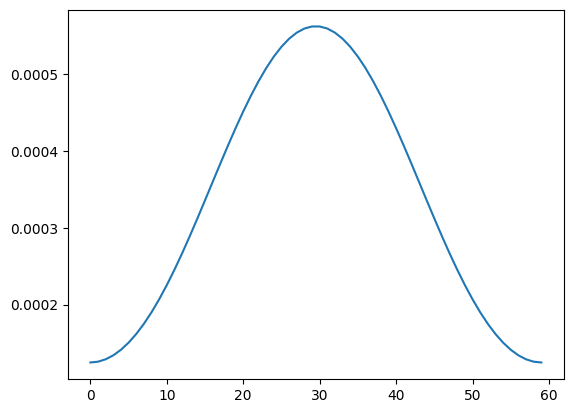

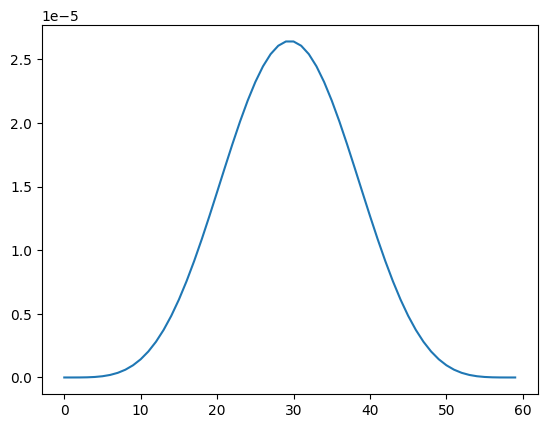

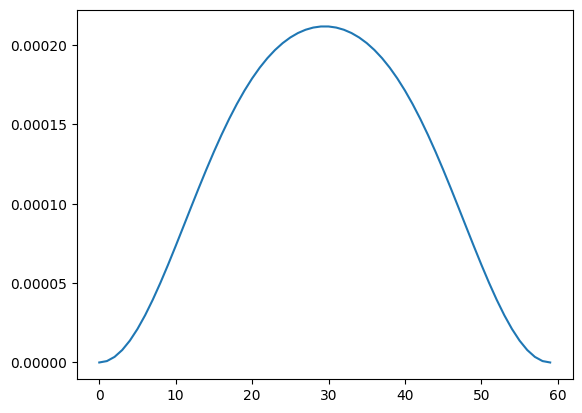

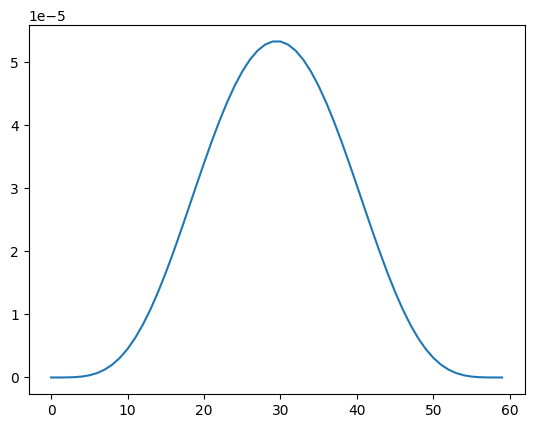

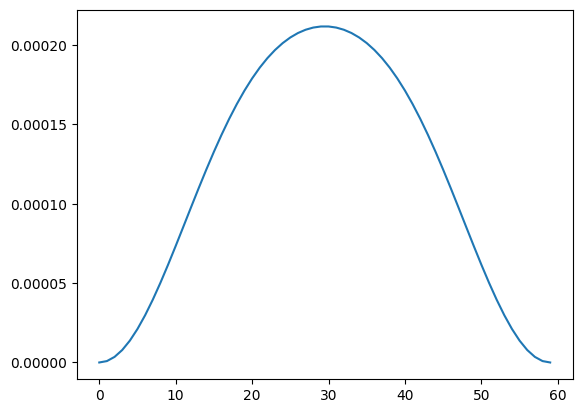

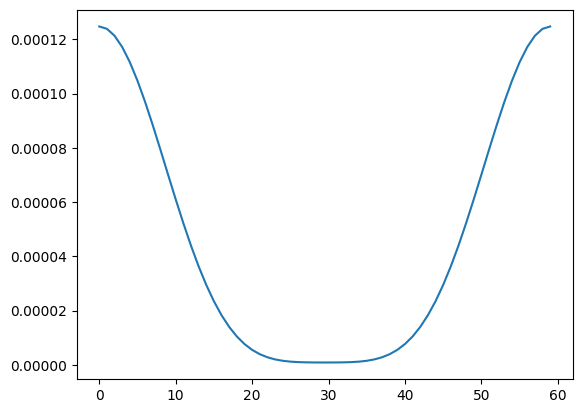

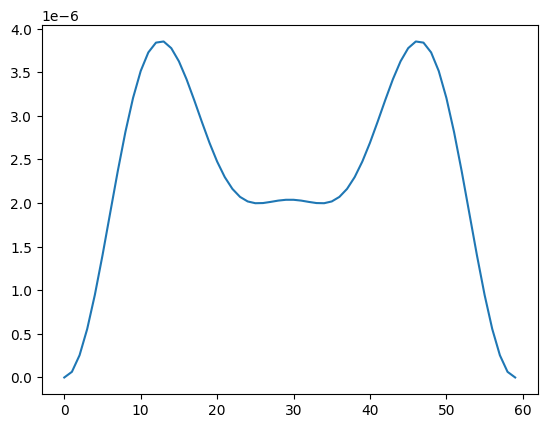

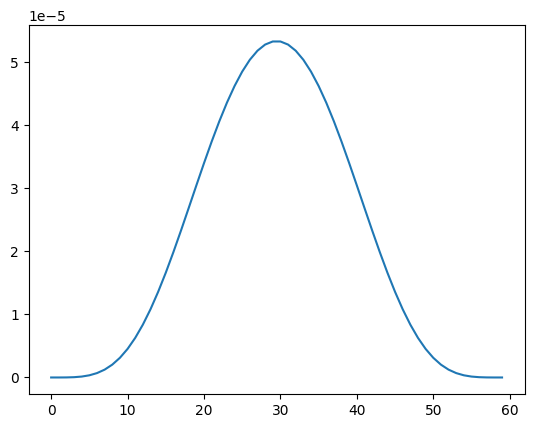

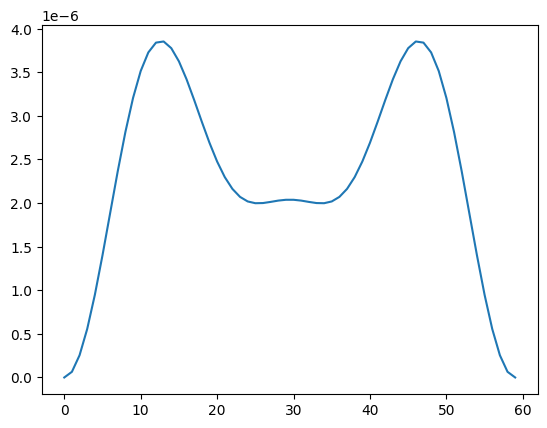

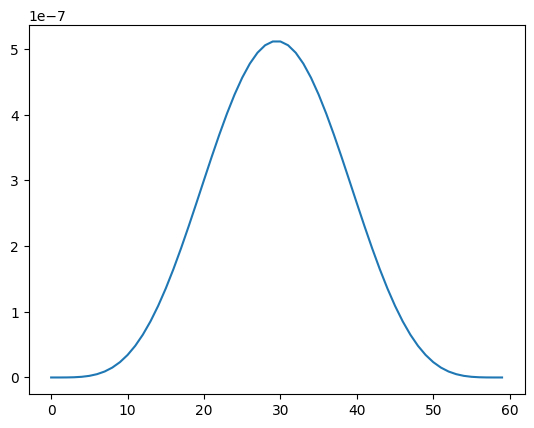

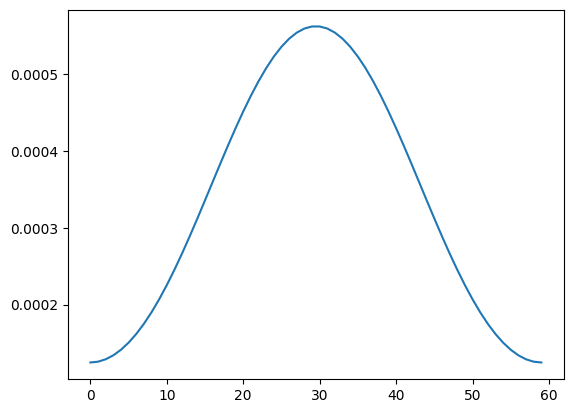

In [4]:
plt.figure()
plt.plot(np.sum(coincidence_probs,1))
final = 0
for i in np.transpose(coincidence_probs):
    final += i
    plt.figure()
    plt.plot(i)
plt.figure()
plt.plot(final)

